# Low Poly Art Tutorial
By Samuel Hilton [here](https://cosmiccoding.com.au/tutorials/lowpoly)

### Constants

In [3]:
IMAGE_1 = 'image_1.jpg'
IMAGE_2 = 'image_2.jpg'
OUTPUT_FOLDER_1 = 'output_images/image_1/'
OUTPUT_FOLDER_2 = 'output_images/image_2/'

### Rotate Input Images

In [4]:
# image = IMAGE_1
image = IMAGE_2
# outdir = OUTPUT_FOLDER_1
outdir = OUTPUT_FOLDER_2

### Imports

In [5]:
import os
import numpy as np
import sys
!{sys.executable} -m pip install --user pygame
!{sys.executable} -m pip install --user pygame.gfxdraw
import pygame
import pygame.gfxdraw
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from collections import defaultdict

Looking in indexes: https://devpi.trustyou.com:3001/trustyou/repo/+simple/
You should consider upgrading via the '/Users/afaan.naqvi/.pyenv/versions/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.
Looking in indexes: https://devpi.trustyou.com:3001/trustyou/repo/+simple/
ERROR: Could not install packages due to an EnvironmentError: Exceeded 30 redirects.

You should consider upgrading via the '/Users/afaan.naqvi/.pyenv/versions/3.7.3/bin/python3.7 -m pip install --upgrade pip' command.
pygame 2.0.1 (SDL 2.0.14, Python 3.7.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Get Image
Get this as greyscale so that it is 2D not 3D data

See wikipedia page for [luma](https://en.wikipedia.org/wiki/Luma_(video))

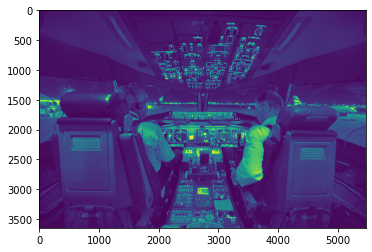

In [4]:
inp = pygame.surfarray.pixels3d(pygame.image.load(image))
perceptual_weight = np.array([0.2126, 0.7152, 0.0722])
grayscale = (inp * perceptual_weight).sum(axis=-1)
plt.imshow(grayscale.T);

### Highlight Details

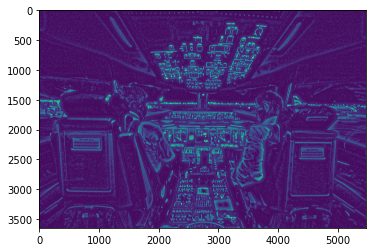

In [5]:
x = gaussian_filter(grayscale, 2, mode="reflect")
x2 = gaussian_filter(grayscale, 30, mode="reflect")

# Take the difference, deweight negatives, normalise
diff = (x - x2)
diff[diff < 0] *= 0.1
diff = np.sqrt(np.abs(diff) / diff.max())

plt.imshow(diff.T)

### Vertices from Image
Use rejection sampling, which means picking a random x, y coordinate and accepting or rejecting it based upon whether a random uniform number is below the luminosity at that point.

So the higher the luminosity, the greater the chance to accept it.

Also generate a buttload of points to start with and just take what we need from that list.

In [6]:
# Function to take reference image and return sample points
def sample(ref, n=1000000):
    np.random.seed(0)
    w, h = x.shape
    xs = np.random.randint(0, w, size=n)
    ys = np.random.randint(0, h, size=n)
    value = ref[xs, ys]
    accept = np.random.random(size=n) < value
    points = np.array([xs[accept], ys[accept]])
    return points.T, value[accept]

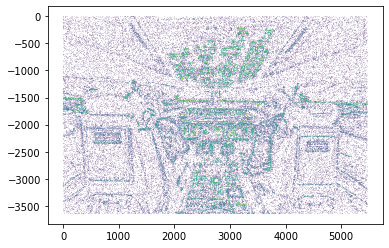

In [7]:
# Plot these to see if they look nicely distributed
samples, v = sample(diff)
plt.scatter(samples[:, 0], -samples[:, 1], c=v, s=0.2, edgecolors="none", cmap="viridis")

### Triangles from Vertices
Using `scipy` and the `Delauny` package

### Color from Triangles
Assign each pixel to a triangle

In [8]:
def get_colour_of_tri(tri, image):
    colours = defaultdict(lambda: [])
    w, h, _ = image.shape
    for i in range(0, w):
        for j in range(0, h):
            # Gets the index of the triangle the point is in
            index = tri.find_simplex((i, j))
            colours[int(index)].append(inp[i, j, :])
    # For each triangle, find the average colour
    for index, array in colours.items():
        colours[index] = np.array(array).mean(axis=0)
    return colours

### Plot the Image
Take a screen, and then for each triangle, use pygame.gfxdraw for anti-aliased drawing.

Plot the outline and the fill both to try and make sure there are no black gaps between images.

In [9]:
def draw(tri, colours, screen, upscale):
    s = screen.copy()
    for key, c in colours.items():
        t = tri.points[tri.simplices[key]]
        pygame.gfxdraw.filled_polygon(s, t * upscale, c)
        pygame.gfxdraw.polygon(s, t * upscale, c)
    return s

### Antimation Drawing Loop
1. Create a base screen and some start vertices as the four corners of the image
2. Jump into a for loop, get vertices and then triangles, determine the colours and plot the image
3. Use an upscale factor of 2 here to shrink it down at the end for better anti-aliasing then the gfxdraw methods

In [10]:
w, h, _ = inp.shape
upscale = 2
screen = pygame.Surface((w * upscale, h * upscale))
screen.fill(inp.mean(axis=(0, 1)))
corners = np.array([(0, 0), (0, h - 1), (w - 1, 0), (w - 1, h - 1)])
points = np.concatenate((corners, samples))

os.makedirs(outdir, exist_ok=True)

for i in range(0, 100):
    n = 5 + i + 2 * int(i**2)
    tri = Delaunay(points[:n, :])
    colours = get_colour_of_tri(tri, inp)
    s = draw(tri, colours, screen, upscale)
    s = pygame.transform.smoothscale(s, (w, h))
    pygame.image.save(s, f"{outdir}{i:04d}.png")

### Turn images into animation with ffmpeg
Per this [stack overflow](https://stackoverflow.com/questions/24961127/how-to-create-a-video-from-images-with-ffmpeg)

- Browse to folder with segential images
- Use command below
- Assuming images in the folder are sequentially named as 0001.png, 0002.png
- `-r` argument is frame rate and `1/0.1` means each image will show for a tenth of a second (so 10 seconds for 100 images)

`ffmpeg -r 1/0.1 -i %04d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4`